# Crossentropy method

This notebook will teach you to solve reinforcement learning with crossentropy method.

In [ ]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [1]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

[2017-02-25 11:45:59,616] Making new env: Taxi-v2


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [2]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [13]:
policy = 1 / n_actions * np.ones((n_states, n_actions))

In [14]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [15]:
def generate_session(t_max=10**4):
    """
    Play game until end or for t_max ticks.
    returns: list of states, list of actions and sum of rewards
    """
    states, actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(n_actions, p=policy[s])
        new_s, r, done, info = env.step(a)
        
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
            
    return states,actions,total_reward  

In [16]:
s,a,r = generate_session()
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) is float

# Training loop
Generate sessions, select N best and fit to those.

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = 2000  #sample this many samples
percentile = 10  #take this percent of session with highest rewards
smoothing = 1e-6  #add this thing to all counts for stability
plot_dist = False

for i in range(200):
    
    sessions = [generate_session() for _ in range(n_samples)]

    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))

    #batch_states: a list of lists of states in each session
    #batch_actions: a list of lists of actions in each session
    #batch_rewards: a list of floats - total rewards at each session
    
    threshold = np.percentile(batch_rewards, percentile)
    
    elite_states = batch_states[batch_rewards >= threshold]
    elite_actions = batch_actions[batch_rewards >= threshold]
    
    elite_states, elite_actions = map(np.concatenate, [elite_states, elite_actions])
    #hint on task above: use np.percentile and numpy-style indexing
    
    #count actions from elite states
    elite_counts = np.zeros_like(policy) + smoothing
    
    for j in range(len(elite_states)):
        elite_counts[elite_states[j], elite_actions[j]] += 1

    a = 0.6
    policy = (1 - a) * policy + a * elite_counts / elite_counts.sum(axis=1, keepdims=True)
    
    print("step %i: mean reward = %.5f\tthreshold = %.1f"%(i, np.mean(batch_rewards), threshold))
    
    if plot_dist:
        sns.distplot(batch_rewards)
        plt.xlabel('reward')
        plt.plot(threshold, 0, 'ro')
        plt.show()

step 0: mean reward = -769.53700	threshold = -866.0
step 1: mean reward = -757.61100	threshold = -857.0
step 2: mean reward = -754.54300	threshold = -848.0
step 3: mean reward = -750.21450	threshold = -839.0
step 4: mean reward = -742.53650	threshold = -839.0
step 5: mean reward = -730.02550	threshold = -830.0
step 6: mean reward = -725.60950	threshold = -821.0
step 7: mean reward = -713.89150	threshold = -812.0
step 8: mean reward = -707.64750	threshold = -812.0
step 9: mean reward = -700.03950	threshold = -794.0
step 10: mean reward = -690.34950	threshold = -794.0
step 11: mean reward = -684.78450	threshold = -785.0
step 12: mean reward = -678.38250	threshold = -776.0
step 13: mean reward = -666.81150	threshold = -776.0
step 14: mean reward = -662.07950	threshold = -767.0
step 15: mean reward = -656.63150	threshold = -758.0
step 16: mean reward = -642.82900	threshold = -749.0
step 17: mean reward = -639.53250	threshold = -740.0
step 18: mean reward = -629.36550	threshold = -740.0
ste

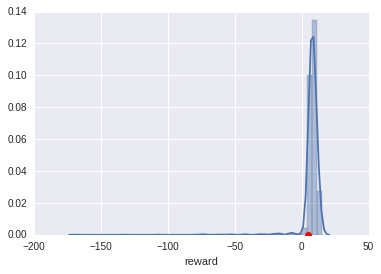

In [19]:
sns.distplot(batch_rewards)
plt.xlabel('reward')
plt.plot(threshold, 0, 'ro')
plt.show()

# Approximate (deep) crossentropy method

In this section we will train a neural network policy for continuous action space game

[2017-02-25 10:01:00,582] Making new env: CartPole-v0


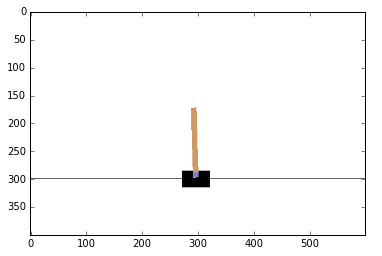

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [14]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(32, 16, 16),
                      activation='relu',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()] * n_actions, range(n_actions));


[2017-02-25 10:01:05,455] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golovanov/repo/git/Practical_RL/week1/videos')
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [15]:
def generate_session(t_max=1000):
    
    states, actions = [], []
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        
        new_s, r, done, info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: 
            break
            
    return states, actions, total_reward
        

In [16]:
from joblib import Parallel, delayed
from collections import deque
from functools import reduce

n_samples = 100
percentile = 50

history_size = 5
history_states = deque(maxlen=history_size)
history_actions = deque(maxlen=history_size)
history_rewards = deque(maxlen=history_size)

for i in range(50):
    sessions = Parallel(n_jobs=4)(delayed(generate_session)() for _ in range(n_samples))

    batch_states, batch_actions, batch_rewards = zip(*sessions)
    
    history_states.append(batch_states)
    history_actions.append(batch_actions)
    history_rewards.append(batch_rewards)

    states = np.array(reduce(lambda x, y: tuple(x) + tuple(y), history_states))
    actions = np.array(reduce(lambda x, y: tuple(x) + tuple(y), history_actions))
    rewards = np.concatenate(history_rewards)

    threshold = np.percentile(rewards, percentile)
    
    elite_states = states[rewards >= threshold]
    elite_actions = actions[rewards >= threshold]
    
    elite_states, elite_actions = map(np.concatenate, [elite_states, elite_actions])
    
    agent.fit(elite_states, elite_actions)

    print("step %i: mean reward = %.5f\tthreshold = %.1f"%(i, np.mean(batch_rewards), threshold))

step 0: mean reward = 19.07000	threshold = 17.0
step 1: mean reward = 20.56000	threshold = 17.0
step 2: mean reward = 20.16000	threshold = 18.0
step 3: mean reward = 24.64000	threshold = 18.0
step 4: mean reward = 25.58000	threshold = 18.0
step 5: mean reward = 24.84000	threshold = 19.0
step 6: mean reward = 32.14000	threshold = 21.0
step 7: mean reward = 26.14000	threshold = 20.0
step 8: mean reward = 28.06000	threshold = 22.0
step 9: mean reward = 29.40000	threshold = 23.0
step 10: mean reward = 42.32000	threshold = 25.0
step 11: mean reward = 49.20000	threshold = 25.5
step 12: mean reward = 38.07000	threshold = 29.0
step 13: mean reward = 41.49000	threshold = 33.0
step 14: mean reward = 50.61000	threshold = 39.0
step 15: mean reward = 60.22000	threshold = 40.0
step 16: mean reward = 54.53000	threshold = 40.0
step 17: mean reward = 80.18000	threshold = 45.5
step 18: mean reward = 79.54000	threshold = 49.0
step 19: mean reward = 88.09000	threshold = 59.0
step 20: mean reward = 81.6700

Залил на gym: https://gym.openai.com/evaluations/eval_Z6aBP14TSKjnNL4TVM4iA

[2017-02-25 11:46:07,555] Making new env: LunarLander-v2
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


step 0: mean reward = -207.85678	threshold = -172.7
step 1: mean reward = -210.41084	threshold = -175.1
step 2: mean reward = -184.94995	threshold = -171.8
step 3: mean reward = -172.79960	threshold = -168.1
step 4: mean reward = -143.52976	threshold = -157.0
step 5: mean reward = -146.76919	threshold = -146.5
step 6: mean reward = -148.23316	threshold = -141.2
step 7: mean reward = -139.13473	threshold = -137.9
step 8: mean reward = -130.68527	threshold = -131.0
step 9: mean reward = -121.67684	threshold = -122.5
step 10: mean reward = -112.80159	threshold = -117.0
step 11: mean reward = -109.54837	threshold = -110.4
step 12: mean reward = -103.30286	threshold = -106.8
step 13: mean reward = -98.51816	threshold = -104.3
step 14: mean reward = -100.94321	threshold = -101.0
step 15: mean reward = -95.39076	threshold = -96.0
step 16: mean reward = -86.63914	threshold = -92.1
step 17: mean reward = -84.05736	threshold = -86.5
step 18: mean reward = -78.29294	threshold = -82.4
step 19: mea

KeyboardInterrupt: 

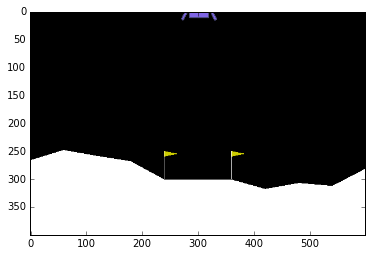

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("LunarLander-v2")
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))


from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(64, 32),
                      activation='relu',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()] * n_actions, range(n_actions));

def generate_session(t_max=1000):
    
    states, actions = [], []
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        
        new_s, r, done, info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: 
            break
            
    return states, actions, total_reward


from joblib import Parallel, delayed
from collections import deque
from functools import reduce

n_samples = 200
percentile = 50

history_size = 3
history_states = deque(maxlen=history_size)
history_actions = deque(maxlen=history_size)
history_rewards = deque(maxlen=history_size)

for i in range(100):
    sessions = Parallel(n_jobs=4)(delayed(generate_session)() for _ in range(n_samples))

    batch_states, batch_actions, batch_rewards = zip(*sessions)

    history_states.append(batch_states)
    history_actions.append(batch_actions)
    history_rewards.append(batch_rewards)

    states = np.array(reduce(lambda x, y: tuple(x) + tuple(y), history_states))
    actions = np.array(reduce(lambda x, y: tuple(x) + tuple(y), history_actions))
    rewards = np.concatenate(history_rewards)

    threshold = np.percentile(rewards, percentile)
    
    elite_states = states[rewards >= threshold]
    elite_actions = actions[rewards >= threshold]
    
    elite_states, elite_actions = map(np.concatenate, [elite_states, elite_actions])
    
    agent.fit(elite_states, elite_actions)

    print("step %i: mean reward = %.5f\tthreshold = %.1f"%(i, np.mean(batch_rewards), threshold))

Залил на gym: https://gym.openai.com/evaluations/eval_OI5rn0qZQr2q3kTyYjm8tA

# Results

In [3]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
gym.upload("./videos/",api_key="sk_T2P9FKPSSLSzdYbs1KVbvA") #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

[2017-02-25 12:24:28,832] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-02-25 12:24:28,837] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week1/videos/openaigym.video.0.18827.video000000.mp4
[2017-02-25 12:24:49,293] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week1/videos/openaigym.video.0.18827.video000001.mp4
[2017-02-25 12:25:02,331] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week1/videos/openaigym.video.0.18827.video000008.mp4
[2017-02-25 12:25:39,589] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week1/videos/openaigym.video.0.18827.video000027.mp4
[2017-02-25 12:26:35,690] Starting new video recorder writing to /home/golovanov/repo/git/Practical_RL/week1/videos/openaigym.video.0.18827.video000064.mp4
[2017-02-25 12:27:27,348] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/golo

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Homework part I

### Tabular correntropy method

You may have noticed that the taxi problem quickly converges from -10k to aroung -500 score (+- 500) and stays there. This is in part because taxi-v2 has some hard-coded randomness in the environment. Other reason is that the percentile was chosen poorly.

### Tasks
- __1.1__ (1 pt) Modify the tabular CEM (CrossEntropyMethod) code to plot distribution of rewards and threshold on each tick.
- __1.2__ (2 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples.

```При увеличении перцентили, распределение быстрее смещается в положителную сторону, но при этом оно раздваивается на два пика. Один ближе к 0, другой (чем выше перцентиль, тем больше пик), - уходит в минус. Фактически, чем ниже перцентиль - тем медленнее и надежнее сходится алгоритм. И чем выше перцентиль, тем вероятнее мы выбираем "удачливые" стратегии, которым потом не везет. Увеличение числа сессий снижает этот недостаток на высоких перцентилях.```


- __1.3__ (2 pts) Tune the algorithm to end up with positive average score.
- __1.4 bonus__ (1 pt) Try to achieve a distribution where 25% or more samples score above +9.0
- __1.5 bonus__ (2 pts) Solve and upload [Taxi-v1](https://gym.openai.com/envs/Taxi-v1) to the openai gym.

It's okay to modify the existing code.


# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ Go to the [gym site](http://gym.openai.com/), register and obtain __api key__.
* __2.2__ (1 pt) Upload your result to gym via gym.upload (see Results tab above, the line you need is commented)
* __2.3__ (3 pts) Pick one of environments: MountainCar-v0 or LunarLander-v2 (or both) and solve it.
  * For MountainCar, learn to finish it in __less than 180 steps__
  * For LunarLander, learn to get reward of __at least +50__
  * See the tips section below, it's kinda important.
  
  
* __2.4__ (1+ pt) Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.
* __Please upload the results to openai gym and send links to all submissions in the e-mail__

### Bonus tasks

* __2.5 bonus__ Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation_)

* __2.6 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (4+ points if it works)
  
* __2.7 bonus__ Use any deep learning framework of your choice to implement policy-gradient (see lectures) on any of those envs (4 +1 per env):
  * CartPole-v0
  * MountainCar-v0
  * LunarLander-v2
  * See __tips on policy gradient__ below.
  

* __2.8 bonus__ take your favorite deep learning framework and try to get above random in [Atari Breakout](https://gym.openai.com/envs/Breakout-v0) with crossentropy method over a convolutional network.
  * Expect at least +10 points if you get this up and running, no deadlines apply ! 
  * __See tips below on where to start, they're cruicially important__

### Tips on policy gradient

* The loss function is very similar to crossentropy method. You can get away with using rewards as  __sample_weights__.
* If your algorithm converges to a poor strategy, try regularizing with entropy or just somehow prevent agent from picking actions deterministically (e.g. when probs = 0,0,1,0,0)
* We will use `lasagne` later in the course so you can try to [learn it](http://lasagne.readthedocs.io/en/latest/user/tutorial.html).
* If you don't want to mess with theano just yet, try [keras](https://keras.io/getting-started/sequential-model-guide/) or [mxnet](http://mxnet.io/tutorials/index.html).


 ### Tips on atari breakout

* There's all the pre-processing and tuning done for you in the code below
* Once you got it working, it's probably a good idea to pre-train with autoencoder or something
* We use last 4 frames as observations to account for ball velocity
* The code below requires ```pip install Image``` and ```pip install gym[atari]```

In [ ]:
from breakout import make_breakout

env = make_breakout()
env.action_space

In [ ]:
#get the initial state
s = env.reset()
print (s.shape)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#plot first observation. Only one frame
plt.imshow(s.swapaxes(1,2).reshape(-1,64).T)

In [ ]:
#next frame
new_s,r,done, _ = env.step(env.action_space.sample())
plt.imshow(new_s.swapaxes(1,2).reshape(-1,64).T)

In [ ]:
#after 10 frames
for _ in range(10):
    new_s,r,done, _ = env.step(env.action_space.sample())

plt.imshow(new_s.swapaxes(1,2).reshape(-1,64).T)

In [ ]:
< tons of your code here or elsewhere >